In [25]:
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
import matplotlib as mpl
from scipy.interpolate import griddata 
import warnings
from netCDF4 import Dataset, num2date, date2num
import os
import datetime as dt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
import numpy as np
sys.path.append('C:/Users/shjo/Bridge/JNUpack/mySO_src/libs/')
warnings.filterwarnings('ignore')
from myTools import myInfo
from myTrend import myfitting2d_sttcs,myRegress3d_sttcs
from myPlot import  figmaster,myClrbr, dta_colr
import matplotlib as mpl
# mpl.use('agg')

t_rng=['1993-01', '2017-12']
### Data Paths ============================================================
NSpath='J:/ACCfront/CTOH_NorthernSubantarcticFront_weekly_1993_2021.nc'
PFpath='J:/ACCfront/CTOH_PolarFront_weekly_1993_2021.nc'
SFpath='J:/ACCfront/CTOH_SubantarcticFront_weekly_1993_2021.nc'

wpth='C:/Users/shjo/OneDrive/mySO/Fronts/tmp/'

lon_rng=[0,360]

ModeN=5
myEEMD_pth='C:/Users/shjo/OneDrive/mySO/EEMD_sigs/OHC700_1993_2020_200E250E_60S53S/Figs/'

### Preparation ============================================================
try :
    os.mkdir(wpth)
except:
    pass
# loc=sys._getframe().f_code.co_filename
# myInfo(loc,wpth)

In [39]:
### Read imfs ============================================================
with open(myEEMD_pth+'EEMD_'+f'{ModeN:02d}'+'_mode.pickle', 'rb') as f:
    data = pickle.load(f)
Esig9317=data.mean(axis=1).loc[t_rng[0]:t_rng[-1]]#.values
Esig9317_std=(Esig9317-Esig9317.mean())/Esig9317.std()
posi_co=np.where(Esig9317_std>1/2)[0]
nega_co=np.where(Esig9317_std<-1/2)[0]

posi_sig=Esig9317_std[posi_co]
nega_sig=Esig9317_std[nega_co]


In [2]:
### Read myDATA =============================================================
mydata_NS=Dataset(NSpath)
NS=mydata_NS['SAF_N'][:]
LON_NS=mydata_NS['longitude'][:]
TIME_NS=mydata_NS['time']

mydata_PF=Dataset(PFpath)
PF=mydata_PF['PF'][:]
LON_PF=mydata_PF['longitude'][:]

mydata_SF=Dataset(SFpath)
SF=mydata_SF['SAF'][:]
LON_SF=mydata_SF['longitude'][:]

In [105]:
### Time processing =============================================
F_Time=num2date(TIME_NS[:],TIME_NS.units).data
F_idx=pd.DatetimeIndex([i.strftime('%Y-%m') for i in F_Time])

### Regrid front data ======================================================
myLon=np.arange(0.25,360-0.25,0.25)
myNS,myPF,mySF=[],[],[]
for ns,pf,sf,lon_ns,lon_pf,lon_sf in zip(NS,PF,SF,LON_NS,LON_PF,LON_SF):
    myNS.append(griddata(lon_ns,ns,myLon))
    myPF.append(griddata(lon_pf,pf,myLon))
    mySF.append(griddata(lon_sf,sf,myLon))
myNS=pd.DataFrame(myNS,index=F_idx).loc[t_rng[0]:t_rng[-1]]
myPF=pd.DataFrame(myPF,index=F_idx).loc[t_rng[0]:t_rng[-1]]
mySF=pd.DataFrame(mySF,index=F_idx).loc[t_rng[0]:t_rng[-1]]

In [128]:
posi_NS=myNS.loc[posi_sig.index.strftime('%Y-%m')].mean()
nega_NS=myNS.loc[nega_sig.index.strftime('%Y-%m')].mean()

posi_PF=myNS.loc[posi_sig.index.strftime('%Y-%m')].mean()
nega_PF=myNS.loc[nega_sig.index.strftime('%Y-%m')].mean()

posi_SF=mySF.loc[posi_sig.index.strftime('%Y-%m')].mean()
nega_SF=mySF.loc[nega_sig.index.strftime('%Y-%m')].mean()

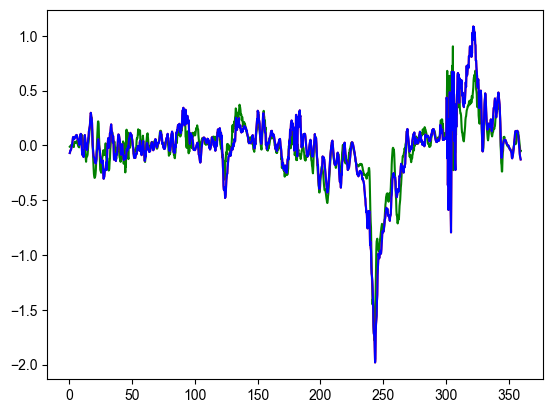

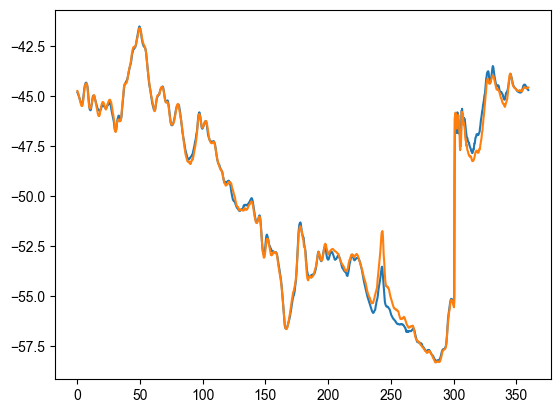

In [133]:
plt.figure(1)
plt.plot(myLon,posi_NS-nega_NS,color='r',zorder=3)
plt.plot(myLon,posi_PF-nega_PF,color='b',zorder=5)
plt.plot(myLon,posi_SF-nega_SF,color='g',zorder=1)

plt.figure(2)
plt.plot(myLon,posi_PF)
plt.plot(myLon,nega_PF)

In [ ]:
def myCrtpy_sph_pcolor_box(LAT,LON,DATA,CMAP,mylevel,myName,wpth):

    
    Spheric=ccrs.SouthPolarStereo(central_longitude=0.0,globe=None)
    PC = ccrs.PlateCarree(central_longitude=0.0,globe=None)
    fig, ax = plt.subplots(1, 1, figsize=(12.5,11),
                    subplot_kw={'projection': Spheric})
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cf.COASTLINE.with_scale("110m"), lw=1,zorder=110)
    ax.add_feature(cartopy.feature.LAND,color=[.75,.75,.75],zorder=100)
    ax.set_title(myName,loc='right',fontdict={'fontsize':32,'fontweight':'regular'}, pad=30)
    gl = ax.gridlines(crs=PC, draw_labels=True,y_inline=False,x_inline=False,
                    linewidth=.6, color='k', alpha=0.45, linestyle='-.')
    gl.rotate_labels=False
    gl.xlabels_top,gl.ylabels_right = True,True
    gl.xlabel_style = gl.ylabel_style = {"size" : 26}
        
    # M=plt.contourf(LON,LAT,DATA,cmap=CMAP,levels=mylevel,transform=PC)
    # M=plt.pcolormesh(LON,LAT,DATA,cmap=CMAP,transform=PC,vmin=-3.5,vmax=3.5)
    ax.set_extent([LON[0][0], LON[0][-1], LAT[0][0], LAT[-1][0]], crs=PC)
    ax.tick_params(axis='both', which='major', labelsize=28)
    # divider = make_axes_locatable(ax)
    # ax_cb = divider.new_horizontal(size="5%", pad=1., axes_class=plt.Axes)
    # fig.add_axes(ax_cb)
    # cb=plt.colorbar(M,extend='both',pad=0.08,cax=ax_cb)
    # cb.set_label(label='', weight='regular',fontsize=28)
    # cb.ax.tick_params(labelsize=19)
    if 0:
        # myName.replace(' ','_')
        plt.savefig(wpth)
    plt.show()
    